In [1]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision.models.detection
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import numpy as np
import matplotlib.pyplot as plt


# Đường dẫn dataset
DATASET_DIR = '/kaggle/input/object-detection-exdark'
IMAGES_DIR = os.path.join(DATASET_DIR, 'ExDark')
ANNOTATIONS_DIR = os.path.join(DATASET_DIR, 'ExDark_Annno')

In [2]:
# Hàm đọc annotations từ cấu trúc thư mục phân cấp
def read_annotations(annotations_dir, images_dir):
    annotations = {}
    
    # Duyệt qua tất cả các thư mục class trong ExDark_Annno
    if not os.path.exists(annotations_dir):
        print(f"Annotations directory not found: {annotations_dir}")
        return {}
    
    for class_folder in os.listdir(annotations_dir):
        class_anno_path = os.path.join(annotations_dir, class_folder)
        if not os.path.isdir(class_anno_path):
            continue
            
        # Duyệt qua thư mục con (có thể có thêm 1 lớp thư mục class)
        for subfolder in os.listdir(class_anno_path):
            subfolder_path = os.path.join(class_anno_path, subfolder)
            if os.path.isdir(subfolder_path):
                # Nếu có thêm 1 lớp thư mục con
                annotation_files_path = subfolder_path
                # print(f"Found subfolder for class {class_folder}: {subfolder_path}")
            else:
                # Nếu file annotation nằm trực tiếp trong thư mục class
                annotation_files_path = class_anno_path
                # print(f"Using class folder for annotations: {class_anno_path}")
                break
        
        # Đọc các file annotation
        if os.path.exists(annotation_files_path):
            for filename in os.listdir(annotation_files_path):
                if filename.endswith('.txt'):
                    # Tìm file ảnh tương ứng
                    img_name_base = filename.replace('.txt', '')
                    
                    # Tìm file ảnh trong thư mục class tương ứng
                    img_class_path = os.path.join(images_dir, class_folder)
                    img_path = None
                    
                    if os.path.exists(img_class_path):
                        for img_file in os.listdir(img_class_path):
                            if img_file.startswith(img_name_base):
                                img_path = os.path.join(class_folder, img_file)
                                # print(f"Found image for annotation {filename}: {img_path}")
                                break
                    
                    if img_path is None:
                        continue
                    
                    # Đọc annotations từ file txt
                    anno_file_path = os.path.join(annotation_files_path, filename)
                    with open(anno_file_path, 'r') as f:
                        lines = f.readlines()
                        objs = []
                        
                        for line in lines:
                            line = line.strip()
                            if line.startswith('%') or not line:  # Bỏ qua comment và dòng trống
                                continue
                                
                            parts = line.split()
                            if len(parts) < 7:  # Ít nhất cần có label, width, height, xmin, ymin, xmax, ymax
                                continue
                            
                            try:
                                label = parts[0]
                                xmin = float(parts[1])
                                ymin = float(parts[2])
                                bbox_width = float(parts[3])
                                bbox_height = float(parts[4])
                                
                                # Chuyển đổi sang format [x
                                xmax = xmin + bbox_width
                                ymax = ymin + bbox_height
                                bbox = [xmin, ymin, xmax, ymax]
                                
                                objs.append({
                                    'label': label,
                                    'bbox': bbox
                                })
                                
                                # print(f"Parsed object: {label}, bbox: {bbox}, img_size: ({width}, {height})")
                            except ValueError:
                                print(f"Error parsing line in {filename}: {line}")
                                continue
                        
                        if objs:  # Chỉ thêm vào nếu có objects
                            annotations[img_path] = objs
    
    print(f"Loaded annotations for {len(annotations)} images")
    return annotations


In [3]:
# Hàm tạo label map từ annotations
def create_label_map(annotations):
    label2idx = {}
    idx = 1
    for objs in annotations.values():
        for obj in objs:
            label = obj['label']
            if label not in label2idx:
                label2idx[label] = idx
                idx += 1
    return label2idx

In [4]:
# Dataset cho object detection
class ExDarkDataset(Dataset):
    def __init__(self, img_dir, annotations, label2idx, transform=None):
        self.img_dir = img_dir
        self.annotations = annotations
        self.label2idx = label2idx
        self.transform = transform
        self.img_files = list(annotations.keys())
        
        print(f"Dataset initialized with {len(self.img_files)} images")
        if len(self.img_files) > 0:
            print(f"Sample image paths: {self.img_files[:10]}")

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_file = self.img_files[idx]
        img_full_path = os.path.join(self.img_dir, img_file)
        
        # Kiểm tra file có tồn tại không
        if not os.path.exists(img_full_path):
            print(f"Image not found: {img_full_path}")
            # Thử tìm với các extension khác
            base_path = os.path.splitext(img_full_path)[0]
            for ext in ['.jpg', '.png', '.jpeg', '.JPG']:
                if os.path.exists(base_path + ext):
                    img_full_path = base_path + ext
                    break
        
        try:
            image = Image.open(img_full_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {img_full_path}: {e}")
            # Tạo ảnh trắng thay thế
            image = Image.new('RGB', (224, 224), color='white')

        objs = self.annotations[img_file]
        boxes = []
        labels = []
        
        for obj in objs:
            bbox = obj['bbox']
            # Đảm bảo bbox có định dạng [xmin, ymin, xmax, ymax] cho Faster R-CNN
            xmin, ymin, xmax, ymax = bbox
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label2idx[obj['label']])

        # Chuyển đổi sang tensor
        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Tạo target dict
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([idx])

        if self.transform:
            image = self.transform(image)

        return image, target

# Transform ảnh
train_transform = transforms.Compose([
    transforms.ToTensor()
])

# Đọc annotations và tạo label map
print("Loading annotations...")
annotations = read_annotations(ANNOTATIONS_DIR, IMAGES_DIR)

print("Creating label map...")
label2idx = create_label_map(annotations)

Loading annotations...
Loaded annotations for 7361 images
Creating label map...


In [5]:
# Tạo dataset
print("Creating dataset...")
dataset = ExDarkDataset(
    img_dir=IMAGES_DIR,
    annotations=annotations,
    label2idx=label2idx,
    transform=train_transform
)
print(f"Dataset size: {len(dataset)}")
try:
    sample_img, sample_target = dataset[0]
    print(f"Sample image shape: {sample_img.shape}")
    print(f"Sample target: {sample_target}")
except Exception as e:
    print(f"Error loading sample: {e}")

# Chia dataset train/val/test
def split_dataset(dataset, train_ratio=0.7, val_ratio=0.1):
    total = len(dataset)
    train_len = int(total * train_ratio)
    val_len = int(total * val_ratio)
    test_len = total - train_len - val_len
    return random_split(dataset, [train_len, val_len, test_len])

train_set, val_set, test_set = split_dataset(dataset)
print(f"Train: {len(train_set)}, Val: {len(val_set)}, Test: {len(test_set)}")

# Custom collate function cho object detection
def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False, collate_fn=collate_fn)

Creating dataset...
Dataset initialized with 7361 images
Sample image paths: ['Motorbike/2015_06098.jpg', 'Motorbike/2015_06044.JPG', 'Motorbike/2015_05956.jpg', 'Motorbike/2015_05958.jpg', 'Motorbike/2015_06047.JPG', 'Motorbike/2015_05886.jpg', 'Motorbike/2015_06054.JPG', 'Motorbike/2015_06187.jpg', 'Motorbike/2015_05993.jpg', 'Motorbike/2015_06090.jpg']
Dataset size: 7361
Sample image shape: torch.Size([3, 746, 770])
Sample target: {'boxes': tensor([[304.,  84., 491., 347.],
        [278., 258., 522., 721.]]), 'labels': tensor([1, 2]), 'image_id': tensor([0])}
Train: 5152, Val: 736, Test: 1473


In [6]:
# Sử dụng model Faster R-CNN cho object detection

def get_detection_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

num_classes = len(label2idx) + 1  # +1 cho background
print(f"Number of classes: {num_classes}")
        
model = get_detection_model(num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model.to(device)

Number of classes: 13


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 231MB/s]


Using device: cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [7]:
def calculate_iou(box1, box2):
    """Tính IoU giữa 2 bounding boxes"""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    if x2 <= x1 or y2 <= y1:
        return 0.0
    
    intersection = (x2 - x1) * (y2 - y1)
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union

def calculate_ap(precisions, recalls):
    """Tính Average Precision"""
    if len(precisions) == 0:
        return 0.0
    
    recalls = np.concatenate(([0], recalls, [1]))
    precisions = np.concatenate(([0], precisions, [0]))
    
    for i in range(len(precisions) - 2, -1, -1):
        precisions[i] = max(precisions[i], precisions[i + 1])
    
    indices = np.where(recalls[1:] != recalls[:-1])[0] + 1
    ap = np.sum((recalls[indices] - recalls[indices - 1]) * precisions[indices])
    return ap

def evaluate_faster_rcnn(predictions, ground_truths):
    """Tính mAP cho Faster R-CNN"""
    iou_threshold=0.5
    # Tạo idx2label để map ngược lại tên class
    idx2label = {v: k for k, v in label2idx.items()}
    
    # Lấy tất cả classes (loại bỏ background class = 0)
    all_classes = set()
    for gt in ground_truths:
        all_classes.update(gt['labels'])
    all_classes = sorted([c for c in all_classes if c > 0])  # Loại bỏ background
    
    if len(all_classes) == 0:
        return 0.0
    
    class_aps = []
    
    for class_id in all_classes:
        detections = []
        num_gt = 0
        
        for img_idx, (pred, gt) in enumerate(zip(predictions, ground_truths)):
            # Ground truth cho class này
            gt_mask = gt['labels'] == class_id
            gt_boxes_class = gt['boxes'][gt_mask]
            num_gt += len(gt_boxes_class)
            
            # Predictions cho class này
            pred_mask = pred['labels'] == class_id
            pred_boxes_class = pred['boxes'][pred_mask]
            pred_scores_class = pred['scores'][pred_mask]
            
            for box, score in zip(pred_boxes_class, pred_scores_class):
                detections.append({
                    'image_idx': img_idx,
                    'box': box,
                    'score': score,
                    'gt_boxes': gt_boxes_class
                })
        
        if num_gt == 0 or len(detections) == 0:
            class_aps.append(0.0)
            continue
        
        # Sắp xếp theo confidence
        detections.sort(key=lambda x: x['score'], reverse=True)
        
        tp = np.zeros(len(detections))
        fp = np.zeros(len(detections))
        matched_gt = {}
        
        for det_idx, detection in enumerate(detections):
            img_idx = detection['image_idx']
            pred_box = detection['box']
            gt_boxes = detection['gt_boxes']
            
            if img_idx not in matched_gt:
                matched_gt[img_idx] = [False] * len(gt_boxes)
            
            max_iou = 0
            max_gt_idx = -1
            
            for gt_idx, gt_box in enumerate(gt_boxes):
                if not matched_gt[img_idx][gt_idx]:
                    iou = calculate_iou(pred_box, gt_box)
                    if iou > max_iou:
                        max_iou = iou
                        max_gt_idx = gt_idx
            
            if max_iou >= iou_threshold and max_gt_idx != -1:
                tp[det_idx] = 1
                matched_gt[img_idx][max_gt_idx] = True
            else:
                fp[det_idx] = 1
        
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        
        precisions = tp_cumsum / (tp_cumsum + fp_cumsum)
        recalls = tp_cumsum / num_gt
        
        ap = calculate_ap(precisions, recalls)
        class_aps.append(ap)
        
        # In ra tên class thay vì class ID
        class_name = idx2label.get(class_id, f"Class_{class_id}")
        print(f"Class '{class_name}' (ID: {class_id}): AP = {ap:.4f}")
    
    mAP = np.mean(class_aps) if class_aps else 0.0
    return mAP

In [8]:
def evaluate(model, test_loader):
    """Hàm đánh giá model - chỉ trả về mAP"""
    model.eval()
    predictions = []
    ground_truths = []
    
    print("Starting evaluation...")
    
    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(tqdm(test_loader, desc="Evaluating")):
            # Chuyển images và targets lên device
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
            
            # Forward pass
            outputs = model(images)
            
            # Thu thập predictions và ground truths
            for output, target in zip(outputs, targets):
                # Lọc predictions có confidence > threshold
                predictions.append({
                    'boxes': output['boxes'].cpu().numpy(),
                    'labels': output['labels'].cpu().numpy(),
                    'scores': output['scores'].cpu().numpy()
                })
                
                ground_truths.append({
                    'boxes': target['boxes'].cpu().numpy(),
                    'labels': target['labels'].cpu().numpy()
                })
    
    print(f"Collected {len(predictions)} predictions and {len(ground_truths)} ground truths")
    
    # Tính mAP
    mAP = evaluate_faster_rcnn(predictions, ground_truths)
    
    return mAP

In [9]:
# Lưu model
def save_model(model, path='/kaggle/working/Faster_RCNN.pth'):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

In [10]:
train_losses = []
train_accuracies = []

# Hàm train model
def train_model(model, train_loader, val_loader, epochs=20, lr=4e-5, warmup_epochs=2, max_norm=1.0):
    best_mAP = -float('inf')
    # Initialize parameters and optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.Adam(params, lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    base_lr = lr
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=epochs, T_mult=1, eta_min=lr/100
    )
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        num_batches = 0
        
        print(f"\nEpoch {epoch+1}/{epochs}")
        loop = tqdm(train_loader, desc="Training")
        
        for images, targets in loop:
            try:
                # Move images and targets to device
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                
                # Forward pass
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())
                
                # Backward pass
                optimizer.zero_grad()
                losses.backward()
                
                # Gradient clipping
                torch.nn.utils.clip_grad_norm_(params, max_norm)
                
                optimizer.step()
                
                # Update loss
                train_loss += losses.item()
                num_batches += 1
                
                # Update progress bar
                avg_loss = train_loss / num_batches if num_batches > 0 else 0
                loop.set_postfix(loss=avg_loss)
                
            except Exception as e:
                print(f"Error in batch: {e}")
                continue
        
        # Step the scheduler
        scheduler.step()
        
        # Calculate average loss
        avg_loss = train_loss / num_batches if num_batches > 0 else 0
        train_losses.append(avg_loss)
        
        # Evaluate on validation set if provided
        val_accuracy = evaluate(model, val_loader)
        if val_accuracy > best_mAP:
            best_mAP = val_accuracy
            save_model(model)
            
        train_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs}, Avg Loss: {avg_loss:.4f}, mAP: {val_accuracy:.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")
    
    return model

In [11]:
model = train_model(model, train_loader, val_loader)


Epoch 1/20


Training: 100%|██████████| 1288/1288 [17:38<00:00,  1.22it/s, loss=0.462]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:21<00:00,  2.25it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7467
Class 'Motorbike' (ID: 2): AP = 0.7611
Class 'Car' (ID: 3): AP = 0.7939
Class 'Bicycle' (ID: 4): AP = 0.7845
Class 'Bus' (ID: 5): AP = 0.7562
Class 'Bottle' (ID: 6): AP = 0.5909
Class 'Chair' (ID: 7): AP = 0.5389
Class 'Table' (ID: 8): AP = 0.4469
Class 'Cup' (ID: 9): AP = 0.5776
Class 'Dog' (ID: 10): AP = 0.5437
Class 'Boat' (ID: 11): AP = 0.6822
Class 'Cat' (ID: 12): AP = 0.4883
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 1/20, Avg Loss: 0.4624, mAP: 0.6426, LR: 0.000040

Epoch 2/20


Training: 100%|██████████| 1288/1288 [16:28<00:00,  1.30it/s, loss=0.362]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.56it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7348
Class 'Motorbike' (ID: 2): AP = 0.7396
Class 'Car' (ID: 3): AP = 0.8009
Class 'Bicycle' (ID: 4): AP = 0.7747
Class 'Bus' (ID: 5): AP = 0.8318
Class 'Bottle' (ID: 6): AP = 0.6236
Class 'Chair' (ID: 7): AP = 0.5241
Class 'Table' (ID: 8): AP = 0.5330
Class 'Cup' (ID: 9): AP = 0.6024
Class 'Dog' (ID: 10): AP = 0.6555
Class 'Boat' (ID: 11): AP = 0.7252
Class 'Cat' (ID: 12): AP = 0.5998
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 2/20, Avg Loss: 0.3617, mAP: 0.6788, LR: 0.000039

Epoch 3/20


Training: 100%|██████████| 1288/1288 [16:30<00:00,  1.30it/s, loss=0.32]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.56it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7866
Class 'Motorbike' (ID: 2): AP = 0.7688
Class 'Car' (ID: 3): AP = 0.7992
Class 'Bicycle' (ID: 4): AP = 0.7513
Class 'Bus' (ID: 5): AP = 0.8107
Class 'Bottle' (ID: 6): AP = 0.6317
Class 'Chair' (ID: 7): AP = 0.5543
Class 'Table' (ID: 8): AP = 0.5718
Class 'Cup' (ID: 9): AP = 0.6821
Class 'Dog' (ID: 10): AP = 0.6750
Class 'Boat' (ID: 11): AP = 0.7063
Class 'Cat' (ID: 12): AP = 0.7191
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 3/20, Avg Loss: 0.3197, mAP: 0.7047, LR: 0.000038

Epoch 4/20


Training: 100%|██████████| 1288/1288 [16:36<00:00,  1.29it/s, loss=0.285]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:10<00:00,  2.60it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7727
Class 'Motorbike' (ID: 2): AP = 0.7998
Class 'Car' (ID: 3): AP = 0.8103
Class 'Bicycle' (ID: 4): AP = 0.8109
Class 'Bus' (ID: 5): AP = 0.8165
Class 'Bottle' (ID: 6): AP = 0.6739
Class 'Chair' (ID: 7): AP = 0.5592
Class 'Table' (ID: 8): AP = 0.5308
Class 'Cup' (ID: 9): AP = 0.6294
Class 'Dog' (ID: 10): AP = 0.7298
Class 'Boat' (ID: 11): AP = 0.6934
Class 'Cat' (ID: 12): AP = 0.6953
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 4/20, Avg Loss: 0.2852, mAP: 0.7102, LR: 0.000036

Epoch 5/20


Training: 100%|██████████| 1288/1288 [16:30<00:00,  1.30it/s, loss=0.256]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.57it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7594
Class 'Motorbike' (ID: 2): AP = 0.8006
Class 'Car' (ID: 3): AP = 0.8130
Class 'Bicycle' (ID: 4): AP = 0.7498
Class 'Bus' (ID: 5): AP = 0.8084
Class 'Bottle' (ID: 6): AP = 0.6573
Class 'Chair' (ID: 7): AP = 0.5994
Class 'Table' (ID: 8): AP = 0.5985
Class 'Cup' (ID: 9): AP = 0.6712
Class 'Dog' (ID: 10): AP = 0.6379
Class 'Boat' (ID: 11): AP = 0.7415
Class 'Cat' (ID: 12): AP = 0.7350
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 5/20, Avg Loss: 0.2561, mAP: 0.7143, LR: 0.000034

Epoch 6/20


Training: 100%|██████████| 1288/1288 [16:28<00:00,  1.30it/s, loss=0.232]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:10<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7569
Class 'Motorbike' (ID: 2): AP = 0.8017
Class 'Car' (ID: 3): AP = 0.7733
Class 'Bicycle' (ID: 4): AP = 0.8337
Class 'Bus' (ID: 5): AP = 0.8179
Class 'Bottle' (ID: 6): AP = 0.6482
Class 'Chair' (ID: 7): AP = 0.6005
Class 'Table' (ID: 8): AP = 0.5508
Class 'Cup' (ID: 9): AP = 0.6849
Class 'Dog' (ID: 10): AP = 0.6795
Class 'Boat' (ID: 11): AP = 0.7335
Class 'Cat' (ID: 12): AP = 0.6839
Epoch 6/20, Avg Loss: 0.2320, mAP: 0.7137, LR: 0.000032

Epoch 7/20


Training: 100%|██████████| 1288/1288 [16:35<00:00,  1.29it/s, loss=0.208]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.57it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7582
Class 'Motorbike' (ID: 2): AP = 0.8523
Class 'Car' (ID: 3): AP = 0.7823
Class 'Bicycle' (ID: 4): AP = 0.7963
Class 'Bus' (ID: 5): AP = 0.8185
Class 'Bottle' (ID: 6): AP = 0.6767
Class 'Chair' (ID: 7): AP = 0.4964
Class 'Table' (ID: 8): AP = 0.5424
Class 'Cup' (ID: 9): AP = 0.6632
Class 'Dog' (ID: 10): AP = 0.7080
Class 'Boat' (ID: 11): AP = 0.7126
Class 'Cat' (ID: 12): AP = 0.7211
Epoch 7/20, Avg Loss: 0.2078, mAP: 0.7107, LR: 0.000029

Epoch 8/20


Training: 100%|██████████| 1288/1288 [16:39<00:00,  1.29it/s, loss=0.187]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:10<00:00,  2.60it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7574
Class 'Motorbike' (ID: 2): AP = 0.7532
Class 'Car' (ID: 3): AP = 0.8033
Class 'Bicycle' (ID: 4): AP = 0.8028
Class 'Bus' (ID: 5): AP = 0.8144
Class 'Bottle' (ID: 6): AP = 0.6029
Class 'Chair' (ID: 7): AP = 0.6032
Class 'Table' (ID: 8): AP = 0.5616
Class 'Cup' (ID: 9): AP = 0.6520
Class 'Dog' (ID: 10): AP = 0.6820
Class 'Boat' (ID: 11): AP = 0.7284
Class 'Cat' (ID: 12): AP = 0.6724
Epoch 8/20, Avg Loss: 0.1873, mAP: 0.7028, LR: 0.000026

Epoch 9/20


Training: 100%|██████████| 1288/1288 [16:32<00:00,  1.30it/s, loss=0.169]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7297
Class 'Motorbike' (ID: 2): AP = 0.8190
Class 'Car' (ID: 3): AP = 0.8079
Class 'Bicycle' (ID: 4): AP = 0.7802
Class 'Bus' (ID: 5): AP = 0.8370
Class 'Bottle' (ID: 6): AP = 0.6593
Class 'Chair' (ID: 7): AP = 0.5693
Class 'Table' (ID: 8): AP = 0.5715
Class 'Cup' (ID: 9): AP = 0.6353
Class 'Dog' (ID: 10): AP = 0.7240
Class 'Boat' (ID: 11): AP = 0.7661
Class 'Cat' (ID: 12): AP = 0.6663
Epoch 9/20, Avg Loss: 0.1689, mAP: 0.7138, LR: 0.000023

Epoch 10/20


Training: 100%|██████████| 1288/1288 [16:26<00:00,  1.31it/s, loss=0.151]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7484
Class 'Motorbike' (ID: 2): AP = 0.8026
Class 'Car' (ID: 3): AP = 0.8037
Class 'Bicycle' (ID: 4): AP = 0.8256
Class 'Bus' (ID: 5): AP = 0.8049
Class 'Bottle' (ID: 6): AP = 0.6507
Class 'Chair' (ID: 7): AP = 0.5745
Class 'Table' (ID: 8): AP = 0.5818
Class 'Cup' (ID: 9): AP = 0.6379
Class 'Dog' (ID: 10): AP = 0.6930
Class 'Boat' (ID: 11): AP = 0.7390
Class 'Cat' (ID: 12): AP = 0.7565
Model saved to /kaggle/working/Faster_RCNN.pth
Epoch 10/20, Avg Loss: 0.1512, mAP: 0.7182, LR: 0.000020

Epoch 11/20


Training: 100%|██████████| 1288/1288 [16:25<00:00,  1.31it/s, loss=0.136]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7320
Class 'Motorbike' (ID: 2): AP = 0.8182
Class 'Car' (ID: 3): AP = 0.8083
Class 'Bicycle' (ID: 4): AP = 0.8153
Class 'Bus' (ID: 5): AP = 0.8254
Class 'Bottle' (ID: 6): AP = 0.6090
Class 'Chair' (ID: 7): AP = 0.5434
Class 'Table' (ID: 8): AP = 0.5850
Class 'Cup' (ID: 9): AP = 0.6429
Class 'Dog' (ID: 10): AP = 0.7166
Class 'Boat' (ID: 11): AP = 0.7762
Class 'Cat' (ID: 12): AP = 0.7247
Epoch 11/20, Avg Loss: 0.1362, mAP: 0.7164, LR: 0.000017

Epoch 12/20


Training: 100%|██████████| 1288/1288 [16:34<00:00,  1.30it/s, loss=0.122]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7397
Class 'Motorbike' (ID: 2): AP = 0.8148
Class 'Car' (ID: 3): AP = 0.7800
Class 'Bicycle' (ID: 4): AP = 0.8095
Class 'Bus' (ID: 5): AP = 0.8045
Class 'Bottle' (ID: 6): AP = 0.6371
Class 'Chair' (ID: 7): AP = 0.5837
Class 'Table' (ID: 8): AP = 0.5663
Class 'Cup' (ID: 9): AP = 0.6279
Class 'Dog' (ID: 10): AP = 0.7058
Class 'Boat' (ID: 11): AP = 0.7506
Class 'Cat' (ID: 12): AP = 0.7567
Epoch 12/20, Avg Loss: 0.1221, mAP: 0.7147, LR: 0.000014

Epoch 13/20


Training: 100%|██████████| 1288/1288 [16:30<00:00,  1.30it/s, loss=0.109]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7325
Class 'Motorbike' (ID: 2): AP = 0.7974
Class 'Car' (ID: 3): AP = 0.7550
Class 'Bicycle' (ID: 4): AP = 0.8101
Class 'Bus' (ID: 5): AP = 0.8117
Class 'Bottle' (ID: 6): AP = 0.6445
Class 'Chair' (ID: 7): AP = 0.5747
Class 'Table' (ID: 8): AP = 0.5721
Class 'Cup' (ID: 9): AP = 0.6577
Class 'Dog' (ID: 10): AP = 0.7210
Class 'Boat' (ID: 11): AP = 0.7261
Class 'Cat' (ID: 12): AP = 0.7101
Epoch 13/20, Avg Loss: 0.1088, mAP: 0.7094, LR: 0.000011

Epoch 14/20


Training: 100%|██████████| 1288/1288 [16:36<00:00,  1.29it/s, loss=0.0963]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7487
Class 'Motorbike' (ID: 2): AP = 0.7739
Class 'Car' (ID: 3): AP = 0.7683
Class 'Bicycle' (ID: 4): AP = 0.7804
Class 'Bus' (ID: 5): AP = 0.8107
Class 'Bottle' (ID: 6): AP = 0.6583
Class 'Chair' (ID: 7): AP = 0.5656
Class 'Table' (ID: 8): AP = 0.5817
Class 'Cup' (ID: 9): AP = 0.6629
Class 'Dog' (ID: 10): AP = 0.7343
Class 'Boat' (ID: 11): AP = 0.6950
Class 'Cat' (ID: 12): AP = 0.7407
Epoch 14/20, Avg Loss: 0.0963, mAP: 0.7100, LR: 0.000009

Epoch 15/20


Training: 100%|██████████| 1288/1288 [16:38<00:00,  1.29it/s, loss=0.0846]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7418
Class 'Motorbike' (ID: 2): AP = 0.8152
Class 'Car' (ID: 3): AP = 0.7751
Class 'Bicycle' (ID: 4): AP = 0.8095
Class 'Bus' (ID: 5): AP = 0.8022
Class 'Bottle' (ID: 6): AP = 0.6160
Class 'Chair' (ID: 7): AP = 0.5563
Class 'Table' (ID: 8): AP = 0.5479
Class 'Cup' (ID: 9): AP = 0.6479
Class 'Dog' (ID: 10): AP = 0.7213
Class 'Boat' (ID: 11): AP = 0.7306
Class 'Cat' (ID: 12): AP = 0.7162
Epoch 15/20, Avg Loss: 0.0846, mAP: 0.7067, LR: 0.000006

Epoch 16/20


Training: 100%|██████████| 1288/1288 [16:29<00:00,  1.30it/s, loss=0.0755]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7364
Class 'Motorbike' (ID: 2): AP = 0.8130
Class 'Car' (ID: 3): AP = 0.7751
Class 'Bicycle' (ID: 4): AP = 0.7863
Class 'Bus' (ID: 5): AP = 0.8081
Class 'Bottle' (ID: 6): AP = 0.5998
Class 'Chair' (ID: 7): AP = 0.5764
Class 'Table' (ID: 8): AP = 0.5482
Class 'Cup' (ID: 9): AP = 0.6383
Class 'Dog' (ID: 10): AP = 0.7327
Class 'Boat' (ID: 11): AP = 0.7125
Class 'Cat' (ID: 12): AP = 0.7364
Epoch 16/20, Avg Loss: 0.0755, mAP: 0.7053, LR: 0.000004

Epoch 17/20


Training: 100%|██████████| 1288/1288 [16:30<00:00,  1.30it/s, loss=0.067]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7419
Class 'Motorbike' (ID: 2): AP = 0.7713
Class 'Car' (ID: 3): AP = 0.7672
Class 'Bicycle' (ID: 4): AP = 0.8044
Class 'Bus' (ID: 5): AP = 0.8144
Class 'Bottle' (ID: 6): AP = 0.6011
Class 'Chair' (ID: 7): AP = 0.5593
Class 'Table' (ID: 8): AP = 0.5690
Class 'Cup' (ID: 9): AP = 0.6507
Class 'Dog' (ID: 10): AP = 0.7563
Class 'Boat' (ID: 11): AP = 0.7491
Class 'Cat' (ID: 12): AP = 0.7298
Epoch 17/20, Avg Loss: 0.0670, mAP: 0.7095, LR: 0.000003

Epoch 18/20


Training: 100%|██████████| 1288/1288 [16:32<00:00,  1.30it/s, loss=0.0605]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.59it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7322
Class 'Motorbike' (ID: 2): AP = 0.7906
Class 'Car' (ID: 3): AP = 0.7687
Class 'Bicycle' (ID: 4): AP = 0.7796
Class 'Bus' (ID: 5): AP = 0.8033
Class 'Bottle' (ID: 6): AP = 0.6004
Class 'Chair' (ID: 7): AP = 0.5363
Class 'Table' (ID: 8): AP = 0.5648
Class 'Cup' (ID: 9): AP = 0.6551
Class 'Dog' (ID: 10): AP = 0.7308
Class 'Boat' (ID: 11): AP = 0.7204
Class 'Cat' (ID: 12): AP = 0.7466
Epoch 18/20, Avg Loss: 0.0605, mAP: 0.7024, LR: 0.000001

Epoch 19/20


Training: 100%|██████████| 1288/1288 [16:31<00:00,  1.30it/s, loss=0.056]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]


Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7318
Class 'Motorbike' (ID: 2): AP = 0.7836
Class 'Car' (ID: 3): AP = 0.7691
Class 'Bicycle' (ID: 4): AP = 0.8026
Class 'Bus' (ID: 5): AP = 0.8148
Class 'Bottle' (ID: 6): AP = 0.6059
Class 'Chair' (ID: 7): AP = 0.5471
Class 'Table' (ID: 8): AP = 0.5623
Class 'Cup' (ID: 9): AP = 0.6559
Class 'Dog' (ID: 10): AP = 0.7257
Class 'Boat' (ID: 11): AP = 0.7294
Class 'Cat' (ID: 12): AP = 0.7439
Epoch 19/20, Avg Loss: 0.0560, mAP: 0.7060, LR: 0.000001

Epoch 20/20


Training: 100%|██████████| 1288/1288 [16:34<00:00,  1.30it/s, loss=0.0532]


Starting evaluation...


Evaluating: 100%|██████████| 184/184 [01:11<00:00,  2.58it/s]

Collected 736 predictions and 736 ground truths
Class 'People' (ID: 1): AP = 0.7308
Class 'Motorbike' (ID: 2): AP = 0.7802
Class 'Car' (ID: 3): AP = 0.7762
Class 'Bicycle' (ID: 4): AP = 0.7923
Class 'Bus' (ID: 5): AP = 0.8176
Class 'Bottle' (ID: 6): AP = 0.6017
Class 'Chair' (ID: 7): AP = 0.5493
Class 'Table' (ID: 8): AP = 0.5695
Class 'Cup' (ID: 9): AP = 0.6576
Class 'Dog' (ID: 10): AP = 0.7221
Class 'Boat' (ID: 11): AP = 0.7277
Class 'Cat' (ID: 12): AP = 0.7399
Epoch 20/20, Avg Loss: 0.0532, mAP: 0.7054, LR: 0.000040


In [12]:
checkpoint = torch.load('/kaggle/working/Faster_RCNN.pth')
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [13]:
test_loader = DataLoader(test_set, batch_size=4, shuffle=False, collate_fn=collate_fn)
print(evaluate(model, test_loader))

Starting evaluation...


Evaluating: 100%|██████████| 369/369 [02:39<00:00,  2.32it/s]


Collected 1473 predictions and 1473 ground truths
Class 'People' (ID: 1): AP = 0.7544
Class 'Motorbike' (ID: 2): AP = 0.7861
Class 'Car' (ID: 3): AP = 0.8154
Class 'Bicycle' (ID: 4): AP = 0.8488
Class 'Bus' (ID: 5): AP = 0.8918
Class 'Bottle' (ID: 6): AP = 0.6031
Class 'Chair' (ID: 7): AP = 0.5844
Class 'Table' (ID: 8): AP = 0.5081
Class 'Cup' (ID: 9): AP = 0.7053
Class 'Dog' (ID: 10): AP = 0.8129
Class 'Boat' (ID: 11): AP = 0.6369
Class 'Cat' (ID: 12): AP = 0.7042
0.7209443004328447


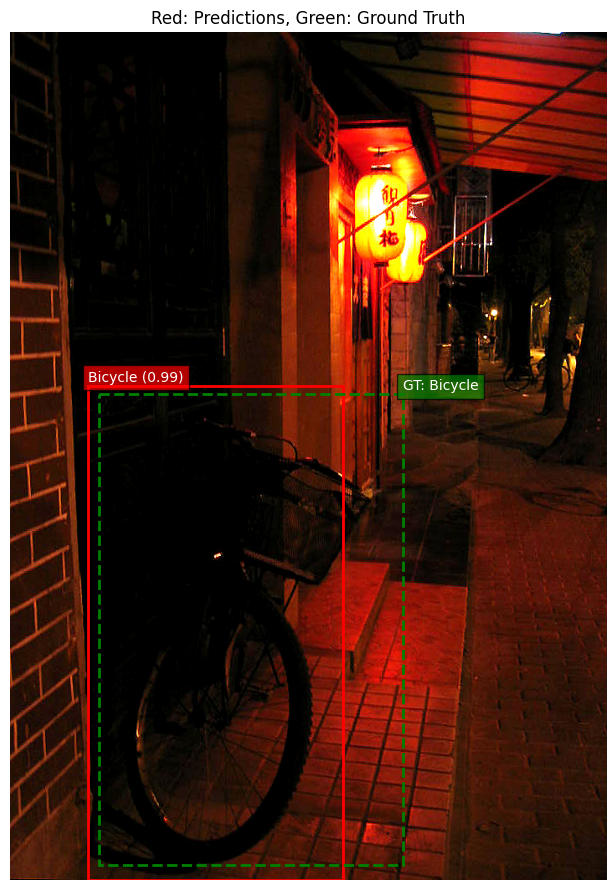

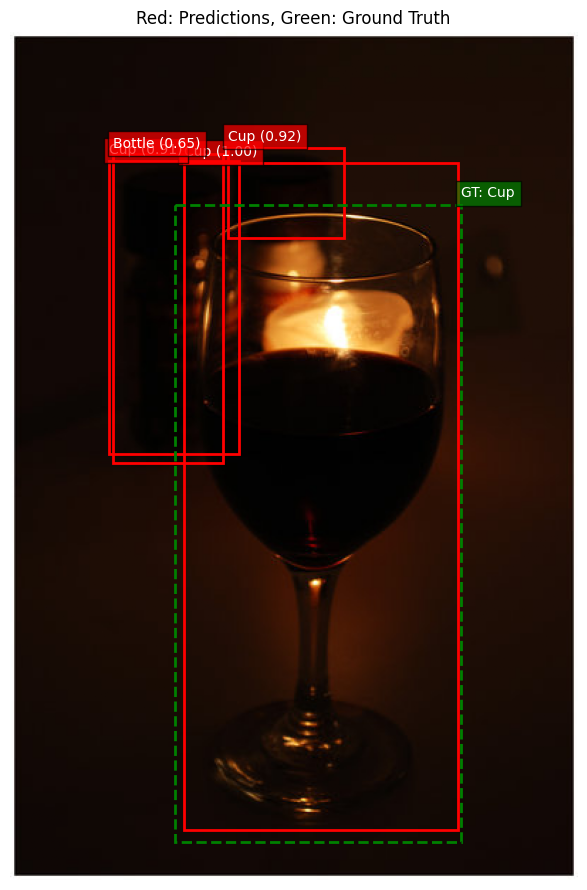

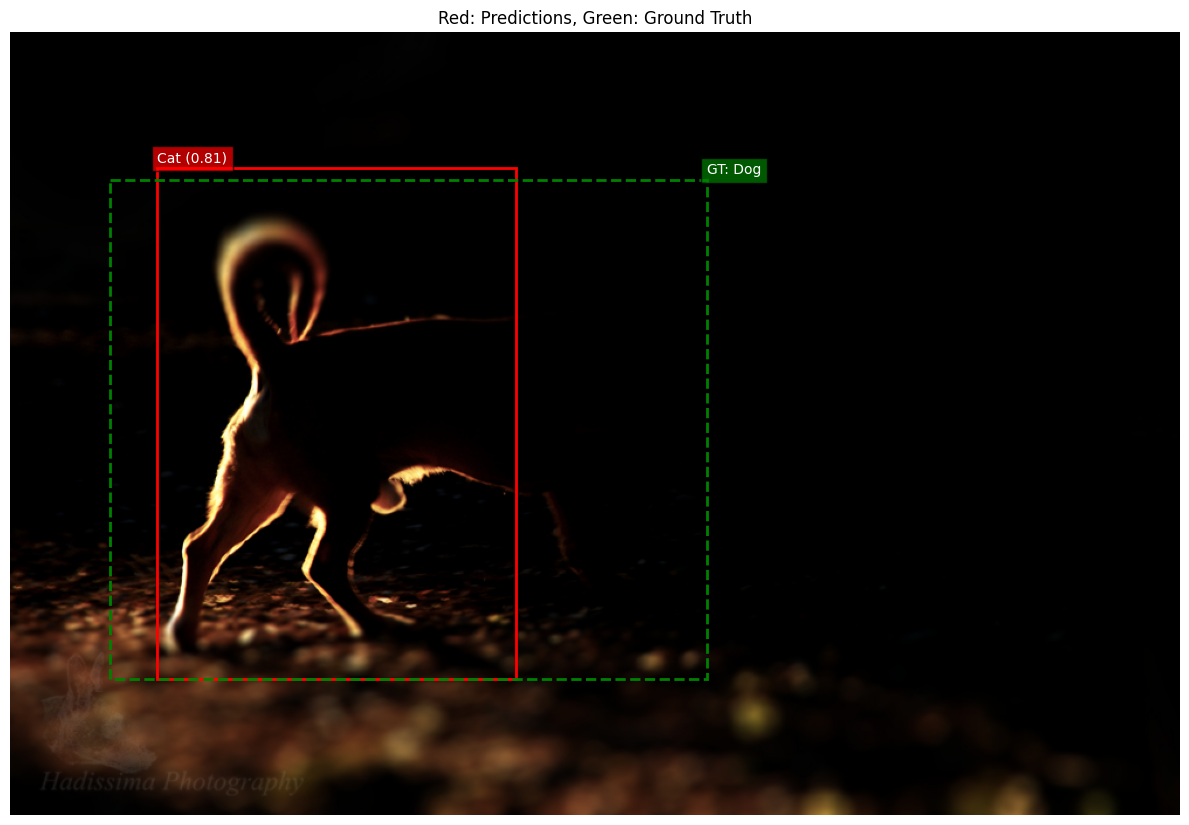

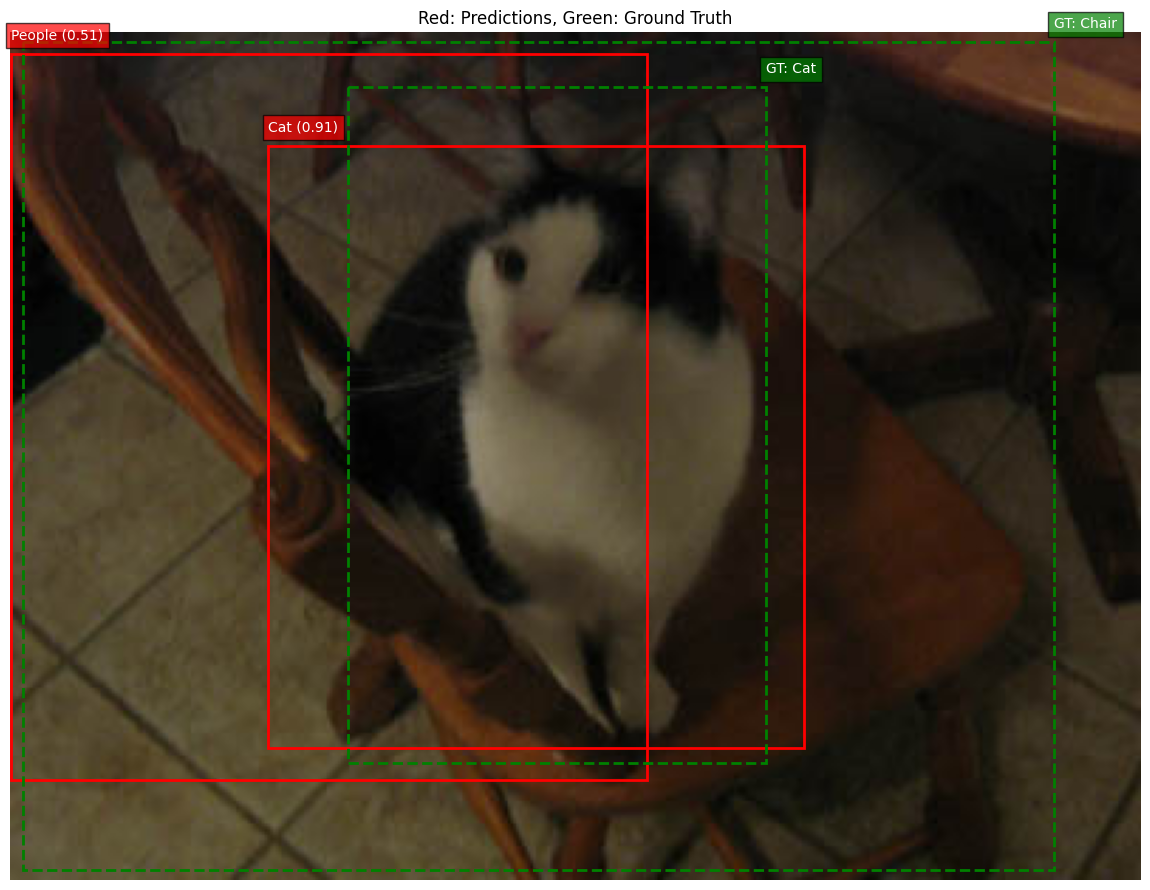

In [14]:
# Hàm hiển thị kết quả prediction
def show_prediction(model, image, target=None, idx2label=None, confidence_threshold=0.5):
    model.eval()
    with torch.no_grad():
        prediction = model([image.to(device)])[0]
        
    # Chuyển đổi bounding boxes về numpy để dễ vẽ
    boxes = prediction['boxes'].cpu().numpy()
    labels = prediction['labels'].cpu().numpy()
    scores = prediction['scores'].cpu().numpy()
    
    # Vẽ bounding boxes
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Chuyển đổi image tensor về format để hiển thị
    if image.shape[0] == 3:  # CHW format
        img_display = image.permute(1, 2, 0).cpu().numpy()
    else:  # HWC format
        img_display = image.cpu().numpy()
    
    # Đảm bảo pixel values trong range [0, 1]
    if img_display.max() > 1.0:
        img_display = img_display / 255.0
    
    ax.imshow(img_display)
    
    # Vẽ prediction boxes (màu đỏ)
    for box, label, score in zip(boxes, labels, scores):
        if score < confidence_threshold:  # Chỉ vẽ nếu confidence > threshold
            continue
            
        xmin, ymin, xmax, ymax = box
        width = xmax - xmin
        height = ymax - ymin
        
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # Hiển thị label và score
        if idx2label and label in idx2label:
            label_name = idx2label[label]
        else:
            label_name = f"Class_{label}"
            
        ax.text(xmin, ymin-5, f"{label_name} ({score:.2f})", 
                color='white', fontsize=10,
                bbox=dict(facecolor='red', alpha=0.7))
    
    # Vẽ ground truth boxes nếu có (màu xanh lá)
    if target is not None:
        gt_boxes = target['boxes'].cpu().numpy()
        gt_labels = target['labels'].cpu().numpy()
        
        for box, label in zip(gt_boxes, gt_labels):
            xmin, ymin, xmax, ymax = box
            width = xmax - xmin
            height = ymax - ymin
            
            rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2,
                                    edgecolor='g', facecolor='none', linestyle='--')
            ax.add_patch(rect)
            
            # Hiển thị ground truth label
            if idx2label and label in idx2label:
                label_name = idx2label[label]
            else:
                label_name = f"Class_{label}"
                
            ax.text(xmax, ymin-5, f"GT: {label_name}", 
                    color='white', fontsize=10,
                    bbox=dict(facecolor='green', alpha=0.7))
    
    ax.set_title("Red: Predictions, Green: Ground Truth")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Hiển thị prediction cho một ảnh trong test set
def show_test_prediction(model, test_set, idx=0, idx2label=None):
    if idx < 0 or idx >= len(test_set):
        print(f"Index {idx} out of bounds for test set of size {len(test_set)}")
        return
    
    try:
        image, target = test_set[idx]
        show_prediction(model, image, target, idx2label)
    except Exception as e:
        print(f"Error showing prediction for index {idx}: {e}")

# Hàm tiện ích để tạo idx2label từ label2idx
def create_idx2label(label2idx):
    return {v: k for k, v in label2idx.items()}

# Sử dụng:
# Tạo mapping ngược từ index về tên class
idx2label = create_idx2label(label2idx)

# Hiển thị kết quả
show_test_prediction(model, test_set, idx=100, idx2label=idx2label)
show_test_prediction(model, test_set, idx=10, idx2label=idx2label)
show_test_prediction(model, test_set, idx=200, idx2label=idx2label)
show_test_prediction(model, test_set, idx=300, idx2label=idx2label)

In [15]:
# Vẽ sơ đồ loss và accuracy
def plot_training_history(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    plt.figure(figsize=(12, 5))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Validation mAP', color='orange')
    plt.title('Validation mAP')
    plt.xlabel('Epochs')
    plt.ylabel('mAP')
    plt.grid()
    plt.legend()
    
    plt.tight_layout()
    plt.show()

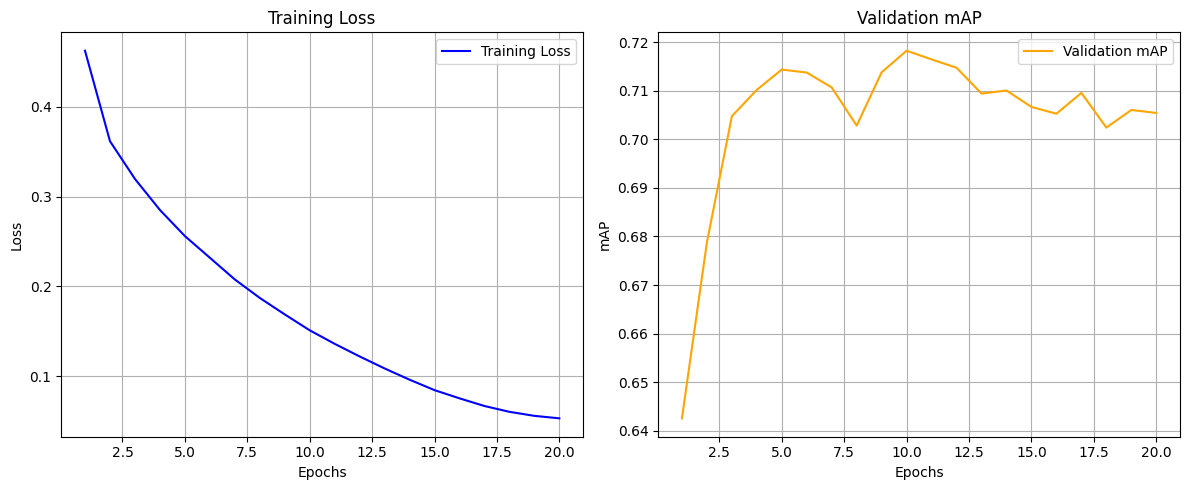

In [16]:
plot_training_history(train_losses, train_accuracies)